In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Loan_dataset_v1.csv')

In [4]:
df.sample(5)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
171149,39,79492,141854,551,79,3,16.89,12,0.48,0,...,False,True,False,True,True,False,False,True,False,True
133705,51,87910,226148,619,84,4,24.26,24,0.18,0,...,False,False,True,True,False,False,False,True,False,False
127832,39,149302,207531,362,5,2,16.60,48,0.60,0,...,False,False,False,False,True,False,True,False,False,False
220483,35,133698,194297,420,57,1,16.23,12,0.12,0,...,False,False,False,True,True,True,False,False,False,True
163251,56,134459,196058,517,49,4,8.00,24,0.14,0,...,True,False,True,False,False,False,False,False,False,True


In [5]:
# df = df.drop('LoanID',axis=1)
df = df.drop(columns=[
    'LoanPurpose_Business',
    'LoanPurpose_Education',
    'LoanPurpose_Home',
    'LoanPurpose_Other'
],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           255347 non-null  int64  
 1   Income                        255347 non-null  int64  
 2   LoanAmount                    255347 non-null  int64  
 3   CreditScore                   255347 non-null  int64  
 4   MonthsEmployed                255347 non-null  int64  
 5   NumCreditLines                255347 non-null  int64  
 6   InterestRate                  255347 non-null  float64
 7   LoanTerm                      255347 non-null  int64  
 8   DTIRatio                      255347 non-null  float64
 9   Default                       255347 non-null  int64  
 10  Education_High School         255347 non-null  bool   
 11  Education_Master's            255347 non-null  bool   
 12  Education_PhD                 255347 non-nul

In [7]:
df['Default'].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

## Data Preparation
   Features and Target

In [8]:
X = df.drop('Default', axis=1)
y = df['Default']


## Train-Test Split

We’ll stratify to maintain class distribution:

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Handling Imbalance

For tree-based models (Decision Tree, Random Forest, XGBoost), we can use class weights instead of oversampling.
For Naive Bayes, we may need SMOTE or undersampling because it’s not tree-based.

### Class weights example for trees:

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = dict(zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
print(class_weights)  # Example output: {0: 0.55, 1: 4.2}


{np.int64(0): np.float64(0.5656918944365983), np.int64(1): np.float64(4.30564454936346)}


### Scaling

Decision Tree, Random Forest, XGBoost: Scaling is not required.

Naive Bayes: GaussianNB expects scaled numeric values for better performance.

In [11]:
# from sklearn.metrics import classification_report

# def evaluate_model(model, X_test, y_test):
#     y_pred = model.predict(X_test)
#     print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Predict class labels
    y_pred = model.predict(X_test)
    
    # Predict probabilities for ROC and PR curves
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]  # Probability for class 1
    else:  # Some models (like SVM) may not have predict_proba
        y_probs = model.decision_function(X_test)
    
    # Classification report
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("=== Confusion Matrix ===")
    print(cm)
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_probs)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC Score: {pr_auc:.4f}")




### Step 1: Prepare Data for Naive Bayes

In [53]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Separate features and target
X = df.drop('Default', axis=1)
y = df['Default']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features only
num_cols = ['Age','Income','LoanAmount','CreditScore','MonthsEmployed','NumCreditLines','InterestRate','LoanTerm','DTIRatio']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Default
0    180555
1     23722
Name: count, dtype: int64
After SMOTE: Default
0    180555
1    180555
Name: count, dtype: int64


In [54]:
# Initialize model
nb_model = GaussianNB()

# Train model
nb_model.fit(X_train_res, y_train_res)


,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [55]:
# Evaluate
# y_pred = nb_model.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

# Use the evaluate_model function we created
evaluate_model(nb_model, X_test, y_test)


=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.94      0.69      0.79     45139
     Default       0.22      0.65      0.32      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.67      0.56     51070
weighted avg       0.85      0.68      0.74     51070

=== Confusion Matrix ===
[[31061 14078]
 [ 2055  3876]]
TN: 31061, FP: 14078, FN: 2055, TP: 3876
ROC-AUC Score: 0.7314
PR-AUC Score: 0.2766


## Naive Bayes: UnderSampling:

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Separate features and target
X = df.drop('Default', axis=1)
y = df['Default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
num_cols = ['Age','Income','LoanAmount','CreditScore','MonthsEmployed',
            'NumCreditLines','InterestRate','LoanTerm','DTIRatio']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# ----- Undersample majority class -----
# Combine X_train and y_train
train_data = X_train.copy()
train_data['Default'] = y_train

# Separate majority and minority
majority = train_data[train_data['Default'] == 0]
minority = train_data[train_data['Default'] == 1]

In [48]:
# Downsample majority to match minority
majority_downsampled = resample(
    majority,
    replace=False,            # sample without replacement
    n_samples=len(minority),  # match minority size
    random_state=42
)

# Combine back to create balanced training data
train_balanced = pd.concat([majority_downsampled, minority])

X_train_res = train_balanced.drop('Default', axis=1)
y_train_res = train_balanced['Default']

print("Before Undersampling:", y_train.value_counts())
print("After Undersampling:", y_train_res.value_counts())

Before Undersampling: Default
0    180555
1     23722
Name: count, dtype: int64
After Undersampling: Default
0    23722
1    23722
Name: count, dtype: int64


In [49]:
# ----- Train Naive Bayes -----
nb_model = GaussianNB()
nb_model.fit(X_train_res, y_train_res)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [50]:
# ----- Evaluate -----
evaluate_model(nb_model, X_test, y_test)

=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.95      0.67      0.78     45139
     Default       0.22      0.71      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.67      0.73     51070

=== Confusion Matrix ===
[[30104 15035]
 [ 1747  4184]]
TN: 30104, FP: 15035, FN: 1747, TP: 4184
ROC-AUC Score: 0.7501
PR-AUC Score: 0.3071


## Decision Tree

In [29]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('Default', axis=1)
y = df['Default']

# Train-test split (stratified to keep class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set class distribution:")
print(y_train.value_counts())
print("Test set class distribution:")
print(y_test.value_counts())


Training set class distribution:
Default
0    180555
1     23722
Name: count, dtype: int64
Test set class distribution:
Default
0    45139
1     5931
Name: count, dtype: int64


In [30]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree with class weights
dt_model = DecisionTreeClassifier(
    max_depth=None,      # Let tree grow fully (you can tune this later)
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)


In [31]:
# Train the Decision Tree
dt_model.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curren

In [32]:
evaluate_model(dt_model, X_test, y_test)


=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.91      0.78      0.84     45139
     Default       0.19      0.39      0.25      5931

    accuracy                           0.73     51070
   macro avg       0.55      0.59      0.55     51070
weighted avg       0.82      0.73      0.77     51070

=== Confusion Matrix ===
[[35042 10097]
 [ 3596  2335]]
TN: 35042, FP: 10097, FN: 3596, TP: 2335
ROC-AUC Score: 0.5933
PR-AUC Score: 0.2146


## HyperParameter Tuning

In [33]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [10, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=params,
    scoring='average_precision',  # PR-AUC
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)


Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 100}


In [34]:
# Use the best estimator from GridSearch
best_dt_model = grid.best_estimator_

# Evaluate on test set
evaluate_model(best_dt_model, X_test, y_test)


=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.94      0.66      0.78     45139
     Default       0.20      0.66      0.31      5931

    accuracy                           0.66     51070
   macro avg       0.57      0.66      0.54     51070
weighted avg       0.85      0.66      0.72     51070

=== Confusion Matrix ===
[[29898 15241]
 [ 2023  3908]]
TN: 29898, FP: 15241, FN: 2023, TP: 3908
ROC-AUC Score: 0.7123
PR-AUC Score: 0.2707


## Random Forest

In [35]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('Default', axis=1)
y = df['Default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set class distribution:")
print(y_train.value_counts())


Training set class distribution:
Default
0    180555
1     23722
Name: count, dtype: int64


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,         # number of trees
    max_depth=None,           # let trees grow fully, can tune later
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',  # handle class imbalance
    random_state=42,
    n_jobs=-1                 # use all cores
)


In [37]:
rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [38]:
evaluate_model(rf_model, X_test, y_test)


=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.90      0.96      0.93     45139
     Default       0.40      0.23      0.29      5931

    accuracy                           0.87     51070
   macro avg       0.65      0.59      0.61     51070
weighted avg       0.85      0.87      0.86     51070

=== Confusion Matrix ===
[[43152  1987]
 [ 4579  1352]]
TN: 43152, FP: 1987, FN: 4579, TP: 1352
ROC-AUC Score: 0.7491
PR-AUC Score: 0.3180


## HyperParameter Tuning:

In [40]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [10, 50, 100],
#     'min_samples_leaf': [5, 20, 50],
#     'criterion': ['gini', 'entropy']
# }

# grid_rf = GridSearchCV(
#     estimator=RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
#     param_grid=param_grid,
#     scoring='average_precision',  # PR-AUC
#     cv=3,
#     n_jobs=-1
# )

# grid_rf.fit(X_train, y_train)
# print("Best Params:", grid_rf.best_params_)


## XGboost

XGBoost is a powerful gradient boosting algorithm that works very well on tabular data and can capture non-linear relationships better than Decision Tree or Random Forest.

Since your dataset is imbalanced, we’ll handle class imbalance using scale_pos_weight instead of SMOTE (preferred for XGBoost), which tells XGBoost to give more weight to the minority class.

### Data Preparation

XGBoost works well with numeric features as-is. Boolean columns (True/False) are automatically converted to 0/1 internally.

In [66]:
from sklearn.model_selection import train_test_split

X = df.drop('Default', axis=1)
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set class distribution:")
print(y_train.value_counts())


Training set class distribution:
Default
0    180555
1     23722
Name: count, dtype: int64


#### Handle Imbalance

XGBoost uses scale_pos_weight:

In [67]:
from xgboost import XGBClassifier
import numpy as np

# Calculate scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print("Scale Pos Weight:", scale_pos_weight)


Scale Pos Weight: 7.61128909872692


#### Initialize XGBoost

In [68]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)


In [69]:
xgb_model.fit(X_train, y_train)


C:\Users\suresh\Desktop\Jupiter\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:53:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [70]:
evaluate_model(xgb_model, X_test, y_test)


=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.94      0.73      0.82     45139
     Default       0.24      0.64      0.35      5931

    accuracy                           0.72     51070
   macro avg       0.59      0.69      0.58     51070
weighted avg       0.86      0.72      0.76     51070

=== Confusion Matrix ===
[[32820 12319]
 [ 2110  3821]]
TN: 32820, FP: 12319, FN: 2110, TP: 3821
ROC-AUC Score: 0.7517
PR-AUC Score: 0.3209


### HyperTuning XGboost: Using Gridsearch
Remember, it consume more time. There is another method too checkout: Optuna(Bayesian Optimization)

In [71]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [200, 500],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }

# grid_xgb = GridSearchCV(
#     estimator=XGBClassifier(
#         objective='binary:logistic', 
#         scale_pos_weight=scale_pos_weight,
#         use_label_encoder=False,
#         eval_metric='logloss',
#         random_state=42,
#         n_jobs=-1
#     ),
#     param_grid=param_grid,
#     scoring='average_precision',  # PR-AUC
#     cv=3,
#     n_jobs=-1
# )

# grid_xgb.fit(X_train, y_train)
# print("Best Params:", grid_xgb.best_params_)

# # Evaluate the best model
# best_xgb_model = grid_xgb.best_estimator_
# evaluate_model(best_xgb_model, X_test, y_test)


## Catboost

In [72]:
from sklearn.model_selection import train_test_split

X = df.drop('Default', axis=1)
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [73]:
neg, pos = y_train.value_counts()
class_weights = [1, neg / pos]   # [weight_0, weight_1]

print(class_weights)


[1, 7.61128909872692]


In [74]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=class_weights,
    random_seed=42,
    verbose=0
)


In [75]:
cat_model.fit(X_train, y_train)


In [76]:
evaluate_model(cat_model, X_test, y_test)


=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.94      0.70      0.80     45139
     Default       0.23      0.69      0.34      5931

    accuracy                           0.70     51070
   macro avg       0.59      0.69      0.57     51070
weighted avg       0.86      0.70      0.75     51070

=== Confusion Matrix ===
[[31523 13616]
 [ 1859  4072]]
TN: 31523, FP: 13616, FN: 1859, TP: 4072
ROC-AUC Score: 0.7586
PR-AUC Score: 0.3311


## LightGBM

In [18]:
scale_pos_weight = neg / pos
print(scale_pos_weight)


7.61128909872692


In [20]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)



In [21]:

lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029633
[LightGBM] [Info] Start training from score -2.029633


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [22]:
evaluate_model(lgb_model, X_test, y_test)


=== Classification Report ===
              precision    recall  f1-score   support

 Non-Default       0.94      0.71      0.81     45139
     Default       0.23      0.66      0.34      5931

    accuracy                           0.70     51070
   macro avg       0.59      0.69      0.57     51070
weighted avg       0.86      0.70      0.75     51070

=== Confusion Matrix ===
[[31915 13224]
 [ 1989  3942]]
TN: 31915, FP: 13224, FN: 1989, TP: 3942
ROC-AUC Score: 0.7551
PR-AUC Score: 0.3260


In [77]:
import joblib

models = {
    "xgb_model": xgb_model,
    "cat_model": cat_model,
    "lgb_model": lgb_model
}

for name, model in models.items():
    joblib.dump(model, f"{name}.pkl")
    print(f"{name}.pkl saved!")



xgb_model.pkl saved!
cat_model.pkl saved!
lgb_model.pkl saved!


# Using SHAP for Feature Importance

Step 1: Import SHAP and create an explainer

In [14]:
import shap
import pickle

# Load the saved model
with open('cat_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
# Convert boolean columns to int
X_test_numeric = X_test.copy()
bool_cols = X_test_numeric.select_dtypes(include='bool').columns
X_test_numeric[bool_cols] = X_test_numeric[bool_cols].astype(int)

# Create explainer
explainer = shap.TreeExplainer(loaded_model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test_numeric)
print(shap_values)


[[-0.54943955  0.78297708 -0.30517008 ... -0.07827953 -0.12920872
   0.11376256]
 [-0.24001512 -0.54225045  0.33781092 ... -0.07449943  0.10745678
   0.12764757]
 [-1.18743825  0.51477691 -0.5744889  ... -0.11379885 -0.14143888
   0.09904915]
 ...
 [ 0.10587845  0.15352532  0.1616     ...  0.07462838 -0.13276044
  -0.12732367]
 [-0.87443519 -0.23393985  0.08080783 ...  0.08388993 -0.11130885
  -0.12244982]
 [ 0.2008512  -0.19782351 -0.32874075 ...  0.08980564 -0.12982342
   0.13009306]]


shap_values will have one value per feature per sample.

For binary classification:

shap_values[1] → contribution towards class 1 (Default)

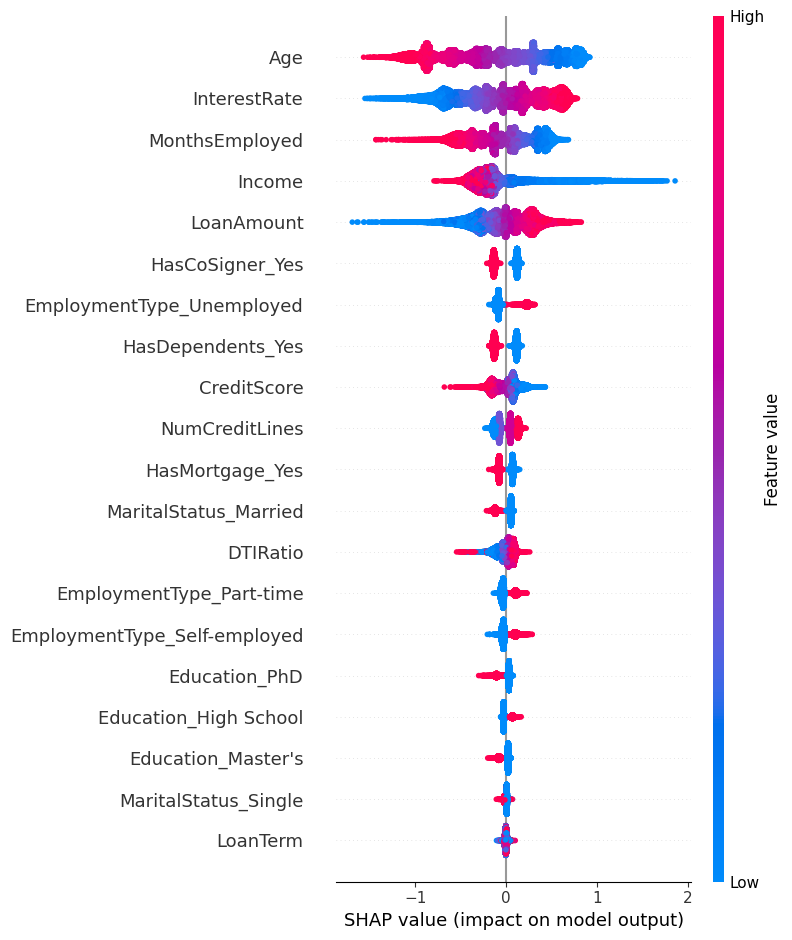

In [15]:
shap.summary_plot(shap_values, X_test_numeric)


This shows overall importance of features.

Red = high feature value, blue = low feature value.

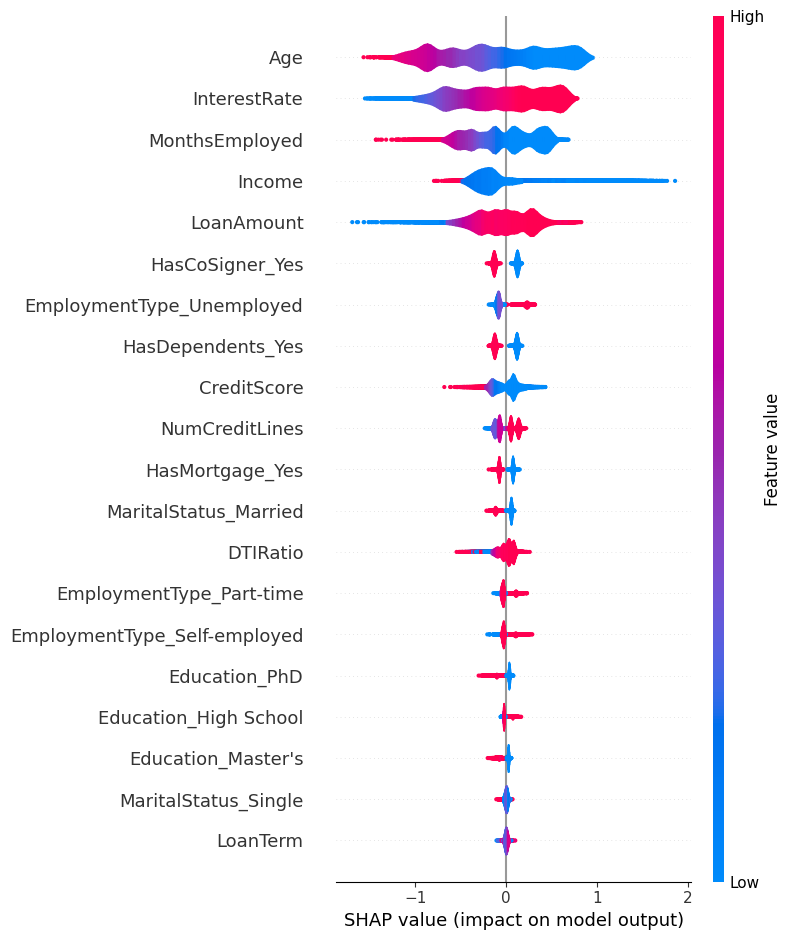

In [82]:
# summary plot works
shap.summary_plot(shap_values, X_test_numeric, plot_type="violin")



Y-axis: feature names (e.g., CreditScore, DTIRatio, Income, HasMortgage_Yes)

X-axis: SHAP value (how much that feature pushes the prediction)

Dots/violin: individual samples

Color: actual feature value

Red → high value

Blue → low value

##### What SHAP values mean

Positive SHAP value → pushes prediction towards Default = 1 (higher chance of default)

Negative SHAP value → pushes prediction towards Default = 0 (lower chance of default)

Example:

CreditScore SHAP values mostly negative → high credit score reduces default probability

DTIRatio SHAP values mostly positive → high debt-to-income increases default probability

## Creating input function:

In [37]:
import pandas as pd

def prepare_user_input(user_data):
    """
    Convert raw user input into model-ready format (same as training CatBoost).
    
    user_data: dict
        Keys: column names as in original dataset
        Example:
        {
            "Age": 30,
            "Income": 50000,
            "LoanAmount": 10000,
            "CreditScore": 650,
            "MonthsEmployed": 24,
            "NumCreditLines": 3,
            "InterestRate": 12.5,
            "LoanTerm": 36,
            "DTIRatio": 40.0,
            "Education": "Master's",
            "EmploymentType": "Self-employed",
            "MaritalStatus": "Single",
            "HasMortgage": "Yes",
            "HasDependents": "No",
            "HasCoSigner": "No"
        }
    Returns: DataFrame with one row, numeric columns ready for CatBoost
    """

    # Step 1: create a DataFrame from input
    df = pd.DataFrame([user_data])

    # Step 2: initialize all one-hot columns with 0
    model_cols = [
        'Age','Income','LoanAmount','CreditScore','MonthsEmployed','NumCreditLines',
        'InterestRate','LoanTerm','DTIRatio',
        "Education_High School","Education_Master's","Education_PhD",
        "EmploymentType_Part-time","EmploymentType_Self-employed","EmploymentType_Unemployed",
        "MaritalStatus_Married","MaritalStatus_Single",
        "HasMortgage_Yes","HasDependents_Yes","HasCoSigner_Yes"
    ]

    model_input = pd.DataFrame(0, index=[0], columns=model_cols)

    # Step 3: fill numeric columns
    numeric_cols = ['Age','Income','LoanAmount','CreditScore','MonthsEmployed',
                    'NumCreditLines','InterestRate','LoanTerm','DTIRatio']
    model_input[numeric_cols] = df[numeric_cols]

    # Step 4: fill one-hot columns
    # Education
    edu_map = {
        'High School': "Education_High School",
        "Master's": "Education_Master's",
        "PhD": "Education_PhD"
    }
    edu_col = edu_map.get(user_data['Education'])
    if edu_col:
        model_input[edu_col] = 1

    # EmploymentType
    emp_map = {
        'Part-time': "EmploymentType_Part-time",
        'Self-employed': "EmploymentType_Self-employed",
        'Unemployed': "EmploymentType_Unemployed"
    }
    emp_col = emp_map.get(user_data['EmploymentType'])
    if emp_col:
        model_input[emp_col] = 1

    # MaritalStatus
    marital_map = {
        'Married': "MaritalStatus_Married",
        'Single': "MaritalStatus_Single"
    }
    marital_col = marital_map.get(user_data['MaritalStatus'])
    if marital_col:
        model_input[marital_col] = 1

    # HasMortgage, HasDependents, HasCoSigner
    yes_no_map = {'Yes':1,'No':0}
    model_input['HasMortgage_Yes'] = yes_no_map.get(user_data['HasMortgage'],0)
    model_input['HasDependents_Yes'] = yes_no_map.get(user_data['HasDependents'],0)
    model_input['HasCoSigner_Yes'] = yes_no_map.get(user_data['HasCoSigner'],0)

    return model_input


This is category inside Category column:
Education: ["Bachelor's" "Master's" 'High School' 'PhD']

EmploymentType: ['Full-time' 'Unemployed' 'Self-employed' 'Part-time']

MaritalStatus: ['Divorced' 'Married' 'Single']

HasMortgage: ['Yes' 'No']

HasDependents: ['Yes' 'No']

HasCoSigner: ['Yes' 'No']

In [74]:
user_data = {
    "Age": 30,
    "Income": 902333,
    "LoanAmount": 30110,
    "CreditScore": 700,
    "MonthsEmployed": 70,
    "NumCreditLines": 1,
    "InterestRate": 20.0,
    "LoanTerm": 12,
    "DTIRatio": 0.1,
    "Education": "High School",
    "EmploymentType": "Self-employed",
    "MaritalStatus": "Single",
    "HasMortgage": "Yes",
    "HasDependents": "No",
    "HasCoSigner": "No"
}

model_input = prepare_user_input(user_data)
# print(model_input)

# Make prediction
pred = loaded_model.predict(model_input)[0]           # 0 or 1
prob = loaded_model.predict_proba(model_input)[0][1]  # probability of Default=1

# Display nicely
if pred == 1:
    print(f"Prediction: DEFAULT")
else:
    print(f"Prediction: NON-DEFAULT")

print(f"Probability of Default: {prob:.2%}")


Prediction: NON-DEFAULT
Probability of Default: 46.37%


In [75]:
min_max = df.describe().loc[['min','max']].T
min_max.rename(columns={'min':'Min Value', 'max':'Max Value'}, inplace=True)
print(min_max)


                Min Value  Max Value
Age                  18.0       69.0
Income            15000.0   149999.0
LoanAmount         5000.0   249999.0
CreditScore         300.0      849.0
MonthsEmployed        0.0      119.0
NumCreditLines        1.0        4.0
InterestRate          2.0       25.0
LoanTerm             12.0       60.0
DTIRatio              0.1        0.9
Default               0.0        1.0


1️⃣ Why small changes may not affect the prediction

Tree-based models like CatBoost, XGBoost, LightGBM make decisions based on splits at certain thresholds:

Example: Suppose one of the trees has a split:

LoanAmount <= 5000 → go left
LoanAmount > 5000 → go right


If your input changes from 5000 → 4000, it still goes left, so the output of that tree does not change.

Many trees together average out to give the same overall probability, especially if the change is small and does not cross meaningful splits.

So even though the numeric value changed, the model’s prediction did not.

shap_values[0] → contribution of each feature towards non-default (0)

shap_values[1] → contribution of each feature towards default (1)

💡 For binary classification, we usually focus on shap_values[1] because we want to explain why default probability is high.

In [76]:
import pandas as pd
import shap

# 1. Prepare numeric input
user_input_numeric = prepare_user_input(user_data)

# 2. Convert booleans to int (Safety check)
bool_cols = user_input_numeric.select_dtypes(include='bool').columns
if not bool_cols.empty:
    user_input_numeric[bool_cols] = user_input_numeric[bool_cols].astype(int)

# 3. Compute SHAP values
shap_results = explainer.shap_values(user_input_numeric)

# 4. Handle output format
# If CatBoost returns a list [class_0, class_1], take class 1 (Default)
if isinstance(shap_results, list):
    user_contributions = shap_results[1][0] 
# If it returns a 2D array [row, feature], take the first row
elif len(shap_results.shape) == 2:
    user_contributions = shap_results[0]
else:
    user_contributions = shap_results

# 5. Create DataFrame for clarity
shap_df_user = pd.DataFrame({
    'Feature': user_input_numeric.columns,
    'Value': user_input_numeric.iloc[0].values,
    'SHAP_Contribution': user_contributions
}).sort_values(by='SHAP_Contribution', ascending=False)

print(shap_df_user)

# Initialize javascript for the plot
# shap.initjs()

# # Get the base value (expected value) for Class 1
# base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value

# # Create the plot
# shap.force_plot(
#     base_val, 
#     user_contributions, 
#     user_input_numeric.iloc[0],
#     matplotlib=False # Set to True if you aren't in a Jupyter/Colab notebook
# )

                         Feature     Value  SHAP_Contribution
0                            Age      30.0           0.432498
6                   InterestRate      20.0           0.390902
19               HasCoSigner_Yes       0.0           0.140062
18             HasDependents_Yes       0.0           0.124588
9          Education_High School       1.0           0.097154
15         MaritalStatus_Married       0.0           0.066282
11                 Education_PhD       0.0           0.040421
10            Education_Master's       0.0           0.032705
13  EmploymentType_Self-employed       1.0          -0.005311
16          MaritalStatus_Single       1.0          -0.008415
7                       LoanTerm      12.0          -0.012497
12      EmploymentType_Part-time       0.0          -0.052432
17               HasMortgage_Yes       1.0          -0.061289
4                 MonthsEmployed      70.0          -0.088833
14     EmploymentType_Unemployed       0.0          -0.089308
3       


🚀 LOAN OFFICER AI: PERSONALIZED ACTION PLAN


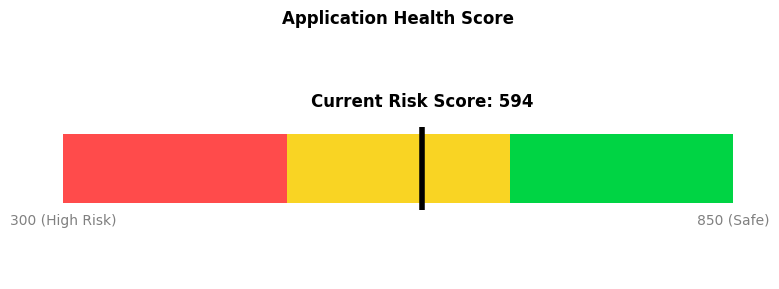


✅ STATUS: APPROVED
Congratulations! Your application meets our credit standards.


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- 1. CONFIGURATION & CATEGORIZATION ---
immutable_features = ['Age', 'Education', 'MaritalStatus']
slow_moving_features = ['CreditScore', 'MonthsEmployed']
actionable_levers = ['LoanAmount', 'Income', 'LoanTerm', 'DTIRatio', 'HasCoSigner']

levers_to_tweak = {
    'LoanAmount': 'down',
    'Income': 'up',
    'CreditScore': 'up'
}

advice_templates = {
    'LoanAmount': {
        'small_gap': "Your requested amount is slightly above the threshold for your current income bracket.",
        'large_gap': "The current loan request significantly exceeds our risk-to-income guidelines.",
        'action': "Consider a down payment of ${gap:,.0f} to bring the loan within approval range."
    },
    'Income': {
        'small_gap': "Your debt-to-income ratio is just shy of our preferred range.",
        'large_gap': "To support a loan of this size, a higher verifiable household income is required.",
        'action': "Adding a co-signer or documenting an additional ${gap:,.0f} in annual income would bridge this gap."
    },
    'CreditScore': {
        'small_gap': "Your credit history is strong, but a few more points would move you into our 'Auto-Approve' tier.",
        'large_gap': "Your current credit profile indicates higher risk than our policy allows.",
        'action': "Focus on reducing revolving credit balances to boost your score by {gap:.0f} points."
    }
}

# --- 2. ENGINE FUNCTIONS (The Brain) ---

def find_minimum_recourse(model, user_input, lever_name, direction='up', step_pct=0.05, max_steps=15):
    """ Finds the smallest single change to flip the prediction. """
    simulated_input = user_input.copy()
    current_val = simulated_input[lever_name].values[0]
    for i in range(1, max_steps + 1):
        adjustment = 1 + (step_pct * i) if direction == 'up' else 1 - (step_pct * i)
        simulated_input[lever_name] = current_val * adjustment
        if model.predict_proba(simulated_input)[0][1] < 0.5:
            return simulated_input[lever_name].values[0], model.predict_proba(simulated_input)[0][1]
    return None, None

def find_combined_recourse(model, user_input, actionable_vars):
    """ Finds a balanced path using multiple small tweaks. """
    best_path = user_input.copy()
    for step in range(1, 15):
        for var, direction in actionable_vars.items():
            adjustment = 1.01 if direction == 'up' else 0.99
            best_path[var] = best_path[var] * adjustment
        if model.predict_proba(best_path)[0][1] < 0.5:
            return best_path, model.predict_proba(best_path)[0][1], step
    return None, None, None

def generate_human_explanation(feature, current_val, target_val):
    """ Translates raw numbers into professional banking advice. """
    gap = abs(target_val - current_val)
    percent_diff = gap / (current_val + 1e-9)
    template = advice_templates.get(feature, {
        'small_gap': f"Adjusting {feature} slightly would help.",
        'large_gap': f"A significant change in {feature} is required.",
        'action': f"Target a change of {gap:,.2f}."
    })
    intensity = 'small_gap' if percent_diff < 0.15 else 'large_gap'
    return f"{template[intensity]} {template['action'].format(gap=gap)}"

# --- 3. VISUALIZATION FUNCTIONS ---

# def plot_user_risk_gauge(probability):
#     score = 850 - (probability * (850-300))
#     fig, ax = plt.subplots(figsize=(8, 2))
#     colors = ['#ff4b4b', '#f9d423', '#00d444'] # Red, Yellow, Green
#     for i, color in enumerate(colors):
#         ax.barh(0, 33.3, left=i*33.3, color=color, height=0.5)
#     position = (score - 300) / (850 - 300) * 100
#     ax.vlines(position, -0.4, 0.4, color='black', lw=4)
#     ax.text(position, 0.6, f'Current Risk Score: {int(score)}', ha='center', fontweight='bold', fontsize=12)
#     ax.set_xlim(0, 100)
#     ax.set_axis_off()
#     plt.title("Application Health Score (Higher is Better)", pad=20)
#     plt.show()

def plot_user_risk_gauge(probability):
    # Convert probability to a 300-850 scale
    score = 850 - (probability * (850-300))
    
    # Increased height from 2 to 3 to prevent overlapping
    fig, ax = plt.subplots(figsize=(8, 3))
    
    colors = ['#ff4b4b', '#f9d423', '#00d444'] # Red, Yellow, Green
    for i, color in enumerate(colors):
        ax.barh(0, 33.33, left=i*33.33, color=color, height=0.5)
    
    # Calculate needle position (0 to 100)
    position = (score - 300) / (850 - 300) * 100
    
    # Draw the needle
    ax.vlines(position, -0.3, 0.3, color='black', lw=4)
    
    # Position the score text slightly higher and add a background box for clarity
    ax.text(position, 0.45, f'Current Risk Score: {int(score)}', 
            ha='center', fontweight='bold', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
    
    # Add scale markers at the bottom to provide context
    ax.text(0, -0.4, '300 (High Risk)', ha='center', fontsize=10, color='gray')
    ax.text(100, -0.4, '850 (Safe)', ha='center', fontsize=10, color='gray')
    
    ax.set_xlim(-5, 105) # Added padding to x-axis
    ax.set_ylim(-0.8, 0.8) # Added vertical space
    ax.set_axis_off()
    
    plt.title("Application Health Score", pad=25, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_decision_heatmap(model, user_data, feat_x, feat_y):
    x_val = user_data[feat_x].values[0]
    y_val = user_data[feat_y].values[0]
    x_range = np.linspace(x_val * 0.7, x_val * 1.3, 10)
    y_range = np.linspace(y_val * 0.7, y_val * 1.3, 10)
    grid_probs = np.zeros((10, 10))
    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            temp = user_data.copy()
            temp[feat_x] = x
            temp[feat_y] = y
            grid_probs[i, j] = model.predict_proba(temp)[0][1]
    plt.figure(figsize=(8, 6))
    sns.heatmap(grid_probs, xticklabels=np.round(y_range, 1), yticklabels=np.round(x_range, 1), 
                cmap='RdYlGn_r', annot=True, fmt=".2f")
    plt.xlabel(feat_y)
    plt.ylabel(feat_x)
    plt.title(f"Decision Boundary Heatmap: {feat_x} vs {feat_y}")
    plt.show()

# --- 4. THE FINAL INTEGRATED REPORT ---

def generate_modern_report(model, user_input, shap_df):
    prob = model.predict_proba(user_input)[0][1]
    
    print("\n" + "="*50)
    print("🚀 LOAN OFFICER AI: PERSONALIZED ACTION PLAN")
    print("="*50)
    
    plot_user_risk_gauge(prob)
    
    if prob < 0.5:
        print("\n✅ STATUS: APPROVED")
        print("Congratulations! Your application meets our credit standards.")
        return

    print("\n❌ STATUS: NOT APPROVED")
    print("\nANALYSIS:")
    # Use SHAP to find the top ACTIONABLE barrier
    actionable_barriers = shap_df[shap_df['Feature'].isin(actionable_levers + slow_moving_features)]
    top_feature = actionable_barriers.iloc[0]['Feature']
    print(f"The primary factor affecting your application is: {top_feature}")

    print("\n✨ PATHS TO APPROVAL:")
    
    # Path A: Single Lever Optimization
    direction = 'down' if top_feature in ['LoanAmount', 'DTIRatio'] else 'up'
    target_val, _ = find_minimum_recourse(model, user_input, top_feature, direction=direction)
    
    if target_val:
        print(f"\nOption 1: The 'Single Focus' Route")
        print(f" 👉 {generate_human_explanation(top_feature, user_input[top_feature].values[0], target_val)}")
    
    # Path B: Multi-Variate optimization
    path_b, _, _ = find_combined_recourse(model, user_input, levers_to_tweak)
    if path_b is not None:
        print(f"\nOption 2: The 'Balanced' Route (Small tweaks to multiple areas)")
        for col in levers_to_tweak.keys():
            diff = path_b[col].values[0] - user_input[col].values[0]
            if abs(diff) > 0.01:
                print(f" 👉 {col}: {'Increase' if diff > 0 else 'Decrease'} by {abs(diff):,.0f}")

    print("\n" + "="*50)
    print("Market Sensitivity Analysis:")
    plot_decision_heatmap(model, user_input, 'Income', 'LoanAmount')

# --- RUNNING THE SYSTEM ---
generate_modern_report(loaded_model, user_input_numeric, shap_df_user)

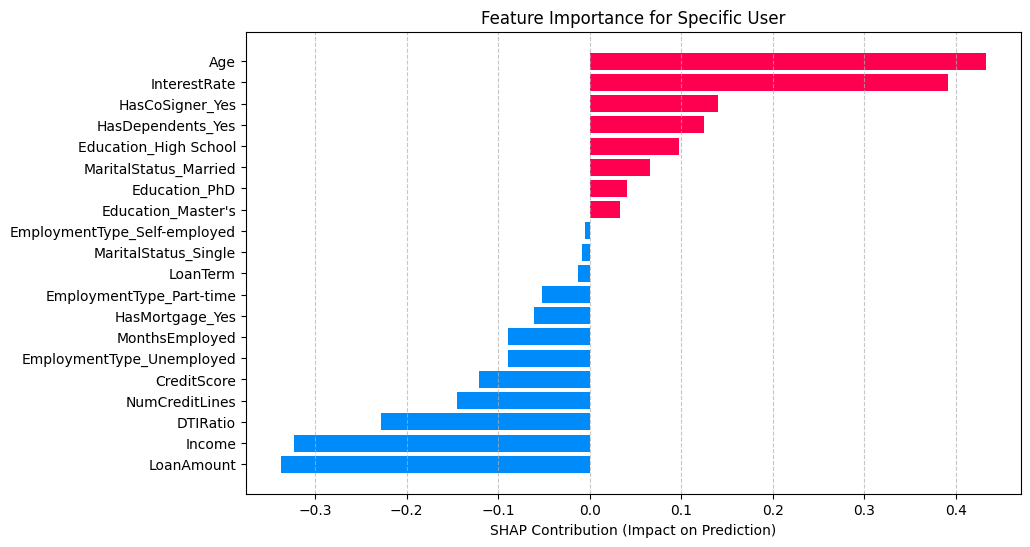

In [78]:
import matplotlib.pyplot as plt

# Define colors: Red for positive (increasing risk), Blue for negative (decreasing risk)
shap_df_user['color'] = ['#ff0051' if x > 0 else '#008bfb' for x in shap_df_user['SHAP_Contribution']]

plt.figure(figsize=(10, 6))
plt.barh(shap_df_user['Feature'], shap_df_user['SHAP_Contribution'], color=shap_df_user['color'])
plt.xlabel('SHAP Contribution (Impact on Prediction)')
plt.title('Feature Importance for Specific User')
plt.gca().invert_yaxis()  # Put highest impact at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()